# Compact Convolutional Transformer for MI-EEG Classification

In [1]:
from model_nail.cct import CCT
from torchinfo import summary

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle 
import torch 
import time
import numpy as np
import pandas as pd 
import random
import mne
import sys
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [3]:
model = CCT(kernel_sizes=[(22, 1), (1, 24)], stride=(1, 1), padding=(0, 0),
            pooling_kernel_size=(3, 3), pooling_stride=(1, 1), pooling_padding=(0, 0),
            n_conv_layers=2, n_input_channels=1,
            in_planes=64, activation=None, # ReLU
            max_pool=False, conv_bias=False,
            dim=64, num_layers=3,
            num_heads=4, num_classes=2, 
            attn_dropout=0.1, dropout=0.1, 
            mlp_size=64, positional_emb="learnable")

In [4]:
summary(model=model,
        input_size=(64, 1, 22, 321),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
CCT (CCT)                                          [64, 1, 22, 321]     [64, 2]              --                   True
├─Tokenizer (tokenizer)                            [64, 1, 22, 321]     [64, 298, 64]        --                   True
│    └─Sequential (conv_layers)                    [64, 1, 22, 321]     [64, 64, 1, 298]     --                   True
│    │    └─Sequential (0)                         [64, 1, 22, 321]     [64, 64, 1, 321]     1,408                True
│    │    └─Sequential (1)                         [64, 64, 1, 321]     [64, 64, 1, 298]     98,304               True
│    └─Flatten (flattener)                         [64, 64, 1, 298]     [64, 64, 298]        --                   --
├─Transformer (transformer)                        [64, 298, 64]        [64, 2]              19,072               True
│    └─Dropout (dropout)                     

## Data Loading

In [5]:
datasets = ['dataset/aBNCI2014001R.pickle', 'dataset/aBNCI2014004R.pickle']

In [6]:
def load_data(filename):
    """
    Load data from a file.
    :param filename: Path to the data file.
    :return: Loaded data.
    """
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [7]:
data = load_data(datasets[0])
class_name = ['left_hand', 'right_hand']
subject = 0
s1 = data[subject]
s1.get_data().shape

(288, 22, 321)

In [8]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if dev.type == 'cuda':
    print('Your GPU device name :', torch.cuda.get_device_name()) 

Your GPU device name : NVIDIA GeForce RTX 3060 Laptop GPU


## Initialization of Parameters and Model

In [37]:
def initialize_model(test_sub, val_sub, n_subj=9):
    """
    Initialize parameters, model, and loss functions.
    :param test_sub: Index of the test subject.
    :param val_sub: Index of the validation subject.
    :param n_subj: Total number of subjects.
    :return: Initialized model and parameters.
    """
    parameters = {
        'batch_size': 32,
        'n_epochs': 100,
        'lr': 3e-5,
        'b1': 0.9,
        'b2': 0.999,
        'test_Sub': test_sub,
        'val_Sub': val_sub,
        'n_subjects': n_subj
    }

    model = CCT(kernel_sizes=[(22, 1), (1, 24)], stride=(1, 1), padding=(0, 0),
                pooling_kernel_size=(3, 3), pooling_stride=(1, 1), pooling_padding=(0, 0),
                n_conv_layers=2, n_input_channels=1, in_planes=64, activation=None,  # ReLU
                max_pool=False, conv_bias=False, dim=64, num_layers=4, num_heads=8, num_classes=2,
                attn_dropout=0.1, dropout=0.1, mlp_size=64, positional_emb="learnable")

    if torch.cuda.is_available():
        model = model.cuda()

    loss_functions = {
        'criterion_l1': nn.L1Loss().cuda(),
        'criterion_l2': nn.MSELoss().cuda(),
        'criterion_cls': nn.CrossEntropyLoss().cuda()
    }

    return model, parameters, loss_functions

## Data Loading and Preprocessing

In [38]:
def get_source_data(test_sub, val_sub, n_subj=9):
    """
    Load and preprocess data.
    :param test_sub: Index of the test subject.
    :param val_sub: Index of the validation subject.
    :param n_subj: Total number of subjects.
    :return: Preprocessed training, validation, and test data and labels.
    """
    # Implement data loading as in your class method
    data = load_data(datasets[0])
    print('Dataset: ', datasets[0])

    train_sub = [i for i in range(n_subj) if i not in (test_sub, val_sub)]

    # Prepare test and validation data
    X_test = data[test_sub].get_data()
    y_test = data[test_sub].events[:, -1]
    
    X_val = data[val_sub].get_data()
    y_val = data[val_sub].events[:, -1]

    # Prepare training data
    X_train = np.concatenate([data[i].get_data() for i in train_sub], axis=0)
    y_train = np.concatenate([data[i].events[:, -1] for i in train_sub], axis=0)
    
    # Expand dimensions and shuffle
    X_train = np.expand_dims(X_train, axis=1)
    X_val = np.expand_dims(X_val, axis=1)
    X_test = np.expand_dims(X_test, axis=1)

    shuffle_num = np.random.permutation(len(X_train))
    X_train = X_train[shuffle_num, :, :, :]
    y_train = y_train[shuffle_num]
        
    # standardize
    target_mean = np.mean(X_train)
    target_std = np.std(X_train)
    X_train = (X_train - target_mean) / target_std
    X_test = (X_test - target_mean) / target_std
    X_val = (X_val - target_mean) / target_std

    # data shape: (trial, conv channel, electrode channel, time samples)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [39]:
def prepare_dataloaders(X_train, y_train, X_val, y_val, batch_size):
    """
    Convert numpy arrays to PyTorch tensors and prepare DataLoaders for training and validation.
    :param X_train: Training data (numpy array).
    :param y_train: Training labels (numpy array).
    :param X_val: Validation data (numpy array).
    :param y_val: Validation labels (numpy array).
    :param batch_size: Batch size for the DataLoader.
    :return: DataLoaders for training and validation.
    """
    # Convert numpy arrays to Tensors
    train_data = torch.from_numpy(X_train).type(torch.cuda.FloatTensor)
    train_labels = torch.from_numpy(y_train - 1).type(torch.cuda.LongTensor)
    val_data = torch.from_numpy(X_val).type(torch.cuda.FloatTensor)
    val_labels = torch.from_numpy(y_val - 1).type(torch.cuda.LongTensor)

    # Prepare DataLoader for training data
    train_dataset = TensorDataset(train_data, train_labels)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # Prepare DataLoader for validation data
    val_dataset = TensorDataset(val_data, val_labels)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

## Model Training

In [40]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        """
        Initialize the EarlyStopping object.
        :param patience: Number of epochs to wait after min has been hit. After this number, training stops.
        :param min_delta: Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            #print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [41]:
def train_model(model, optimizer, loss_functions, train_loader, val_loader, parameters, early_stopping):
    """
    Train the model.
    :param model: The neural network model to train.
    :param optimizer: Optimizer for the model.
    :param criterion_cls: Loss function for classification.
    :param train_loader: DataLoader for training data.
    :param val_loader: DataLoader for validation data.
    :param n_epochs: Number of epochs to train the model.
    :return: Trained model.
    """
    # Lists to keep track of metrics
    train_losses, val_losses, val_accuracies = [], [], []
    
    # Training loop
    for epoch in range(parameters['n_epochs']):
        model.train()
        train_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images).cuda()
            labels = Variable(labels).cuda()

            # Forward pass
            outputs = model(images)
            loss = loss_functions['criterion_cls'](outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        # Validation accuracy
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = Variable(images).cuda()
                labels = Variable(labels).cuda()
                outputs = model(images)
                loss = loss_functions['criterion_cls'](outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            # Calculate average losses and accuracy
            train_loss = train_loss / len(train_loader)
            val_loss = val_loss / len(val_loader)
            val_accuracy = 100 * correct / total
            print(f'Epoch [{epoch+1}/{parameters["n_epochs"]}], Train Loss: {loss.item():.4f}, Val Acc: {val_accuracy:.2f}%')
            
        # Append metrics to lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Check early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return model, train_losses, val_losses, val_accuracies

## Model Evaluation

In [42]:
def test_model(model, criterion_cls, test_loader):
    """
    Test the model using the test dataset.
    :param model: The trained neural network model.
    :param criterion_cls: Loss function for classification.
    :param test_loader: DataLoader for test data.
    :return: Test accuracy and test loss.
    """
    # Evaluate the model
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = Variable(images).cuda()
            labels = Variable(labels).cuda()

            outputs = model(images)
            loss = criterion_cls(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    
    return test_accuracy, test_loss

seed is 1546
Val Subject 2:
Dataset:  dataset/aBNCI2014001R.pickle
Epoch [1/100], Train Loss: 0.6910, Val Acc: 48.26%
Epoch [2/100], Train Loss: 0.6825, Val Acc: 50.00%
Epoch [3/100], Train Loss: 0.6885, Val Acc: 50.00%
Epoch [4/100], Train Loss: 0.7074, Val Acc: 50.00%
Epoch [5/100], Train Loss: 0.6868, Val Acc: 50.35%
Epoch [6/100], Train Loss: 0.6754, Val Acc: 54.51%
Epoch [7/100], Train Loss: 0.7205, Val Acc: 52.78%
Epoch [8/100], Train Loss: 0.7197, Val Acc: 52.43%
Epoch [9/100], Train Loss: 0.7185, Val Acc: 54.86%
Epoch [10/100], Train Loss: 0.7235, Val Acc: 59.72%
Epoch [11/100], Train Loss: 0.8310, Val Acc: 52.78%
Epoch [12/100], Train Loss: 0.7795, Val Acc: 56.25%
Epoch [13/100], Train Loss: 0.7485, Val Acc: 55.21%
Epoch [14/100], Train Loss: 0.8267, Val Acc: 54.51%
Epoch [15/100], Train Loss: 0.7740, Val Acc: 55.56%
Epoch [16/100], Train Loss: 0.7978, Val Acc: 59.03%
Early stopping


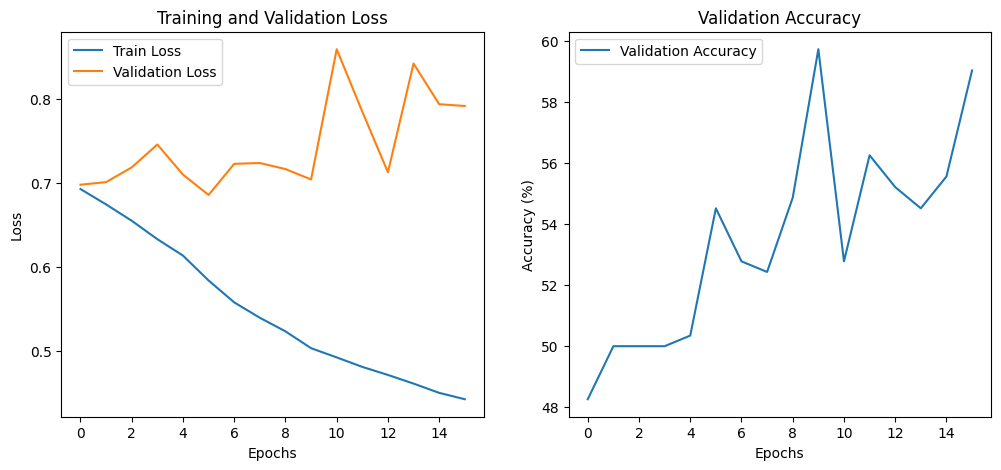

Test Loss: 0.4516, Test Accuracy: 78.47%
Test Subject 1: Test Acc = 78.47%, Test Loss = 0.4516
Training complete in 0m 49s

seed is 1582
Val Subject 3:
Dataset:  dataset/aBNCI2014001R.pickle
Epoch [1/100], Train Loss: 0.7005, Val Acc: 36.46%
Epoch [2/100], Train Loss: 0.7042, Val Acc: 37.15%
Epoch [3/100], Train Loss: 0.7016, Val Acc: 50.35%
Epoch [4/100], Train Loss: 0.6850, Val Acc: 63.89%
Epoch [5/100], Train Loss: 0.6689, Val Acc: 69.79%
Epoch [6/100], Train Loss: 0.6092, Val Acc: 77.43%
Epoch [7/100], Train Loss: 0.5482, Val Acc: 80.56%
Epoch [8/100], Train Loss: 0.4812, Val Acc: 85.42%
Epoch [9/100], Train Loss: 0.4117, Val Acc: 88.89%
Epoch [10/100], Train Loss: 0.3838, Val Acc: 87.50%
Epoch [11/100], Train Loss: 0.3925, Val Acc: 86.11%
Epoch [12/100], Train Loss: 0.3363, Val Acc: 90.97%
Epoch [13/100], Train Loss: 0.3341, Val Acc: 89.93%
Epoch [14/100], Train Loss: 0.3881, Val Acc: 81.60%
Epoch [15/100], Train Loss: 0.2963, Val Acc: 89.58%
Epoch [16/100], Train Loss: 0.2903, Va

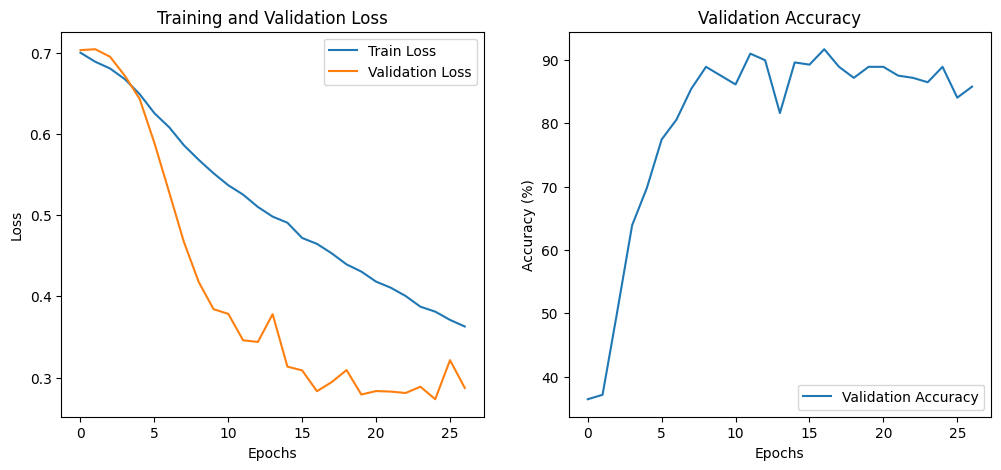

Test Loss: 0.8317, Test Accuracy: 55.90%
Test Subject 2: Test Acc = 55.90%, Test Loss = 0.8317
Training complete in 1m 23s

seed is 1944
Val Subject 4:
Dataset:  dataset/aBNCI2014001R.pickle
Epoch [1/100], Train Loss: 0.6813, Val Acc: 50.00%
Epoch [2/100], Train Loss: 0.6823, Val Acc: 53.47%
Epoch [3/100], Train Loss: 0.6723, Val Acc: 55.21%
Epoch [4/100], Train Loss: 0.6624, Val Acc: 57.29%
Epoch [5/100], Train Loss: 0.6550, Val Acc: 65.28%
Epoch [6/100], Train Loss: 0.6347, Val Acc: 64.93%
Epoch [7/100], Train Loss: 0.6116, Val Acc: 67.36%
Epoch [8/100], Train Loss: 0.6556, Val Acc: 63.89%
Epoch [9/100], Train Loss: 0.6190, Val Acc: 68.06%
Epoch [10/100], Train Loss: 0.5869, Val Acc: 68.40%
Epoch [11/100], Train Loss: 0.7210, Val Acc: 62.15%
Epoch [12/100], Train Loss: 0.6646, Val Acc: 63.54%
Epoch [13/100], Train Loss: 0.8172, Val Acc: 56.25%
Epoch [14/100], Train Loss: 0.6668, Val Acc: 65.62%
Epoch [15/100], Train Loss: 0.8125, Val Acc: 59.38%
Epoch [16/100], Train Loss: 1.1833, Va

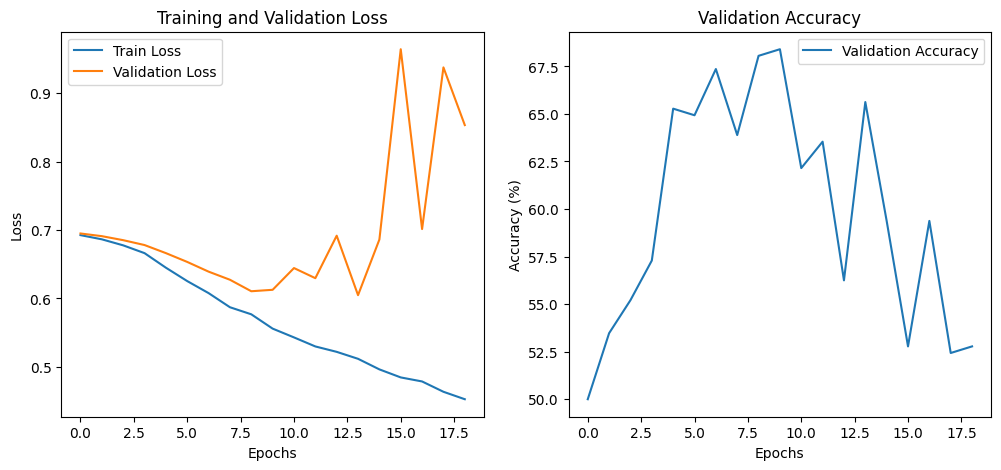

Test Loss: 0.2395, Test Accuracy: 90.97%
Test Subject 3: Test Acc = 90.97%, Test Loss = 0.2395
Training complete in 0m 59s

seed is 796
Val Subject 5:
Dataset:  dataset/aBNCI2014001R.pickle
Epoch [1/100], Train Loss: 0.7000, Val Acc: 50.00%
Epoch [2/100], Train Loss: 0.6959, Val Acc: 49.31%
Epoch [3/100], Train Loss: 0.6895, Val Acc: 50.35%
Epoch [4/100], Train Loss: 0.6862, Val Acc: 54.51%
Epoch [5/100], Train Loss: 0.6860, Val Acc: 54.17%
Epoch [6/100], Train Loss: 0.6683, Val Acc: 54.17%
Epoch [7/100], Train Loss: 0.7139, Val Acc: 53.12%
Epoch [8/100], Train Loss: 0.7720, Val Acc: 50.35%
Epoch [9/100], Train Loss: 0.7191, Val Acc: 54.51%
Epoch [10/100], Train Loss: 0.6631, Val Acc: 50.69%
Epoch [11/100], Train Loss: 0.7255, Val Acc: 50.69%
Early stopping


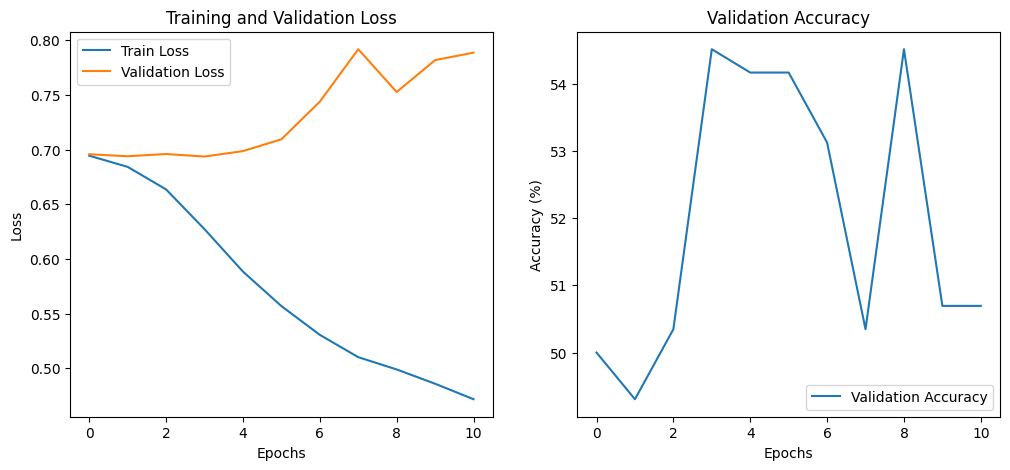

Test Loss: 0.7078, Test Accuracy: 60.42%
Test Subject 4: Test Acc = 60.42%, Test Loss = 0.7078
Training complete in 0m 35s

seed is 1230
Val Subject 6:
Dataset:  dataset/aBNCI2014001R.pickle
Epoch [1/100], Train Loss: 0.7046, Val Acc: 49.65%
Epoch [2/100], Train Loss: 0.7046, Val Acc: 50.00%
Epoch [3/100], Train Loss: 0.7037, Val Acc: 50.00%
Epoch [4/100], Train Loss: 0.6995, Val Acc: 51.74%
Epoch [5/100], Train Loss: 0.6890, Val Acc: 62.50%
Epoch [6/100], Train Loss: 0.6879, Val Acc: 64.24%
Epoch [7/100], Train Loss: 0.7150, Val Acc: 63.19%
Epoch [8/100], Train Loss: 0.7314, Val Acc: 65.97%
Epoch [9/100], Train Loss: 0.7458, Val Acc: 65.62%
Epoch [10/100], Train Loss: 0.7636, Val Acc: 62.85%
Epoch [11/100], Train Loss: 0.7943, Val Acc: 65.97%
Epoch [12/100], Train Loss: 0.7881, Val Acc: 64.24%
Epoch [13/100], Train Loss: 0.8010, Val Acc: 64.93%
Epoch [14/100], Train Loss: 0.8092, Val Acc: 63.54%
Epoch [15/100], Train Loss: 0.8443, Val Acc: 64.93%
Epoch [16/100], Train Loss: 0.9009, Va

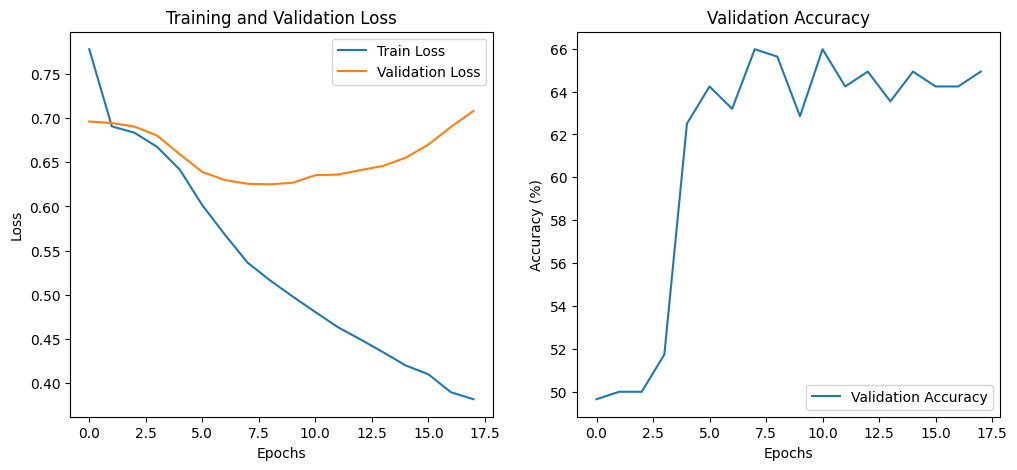

Test Loss: 0.9485, Test Accuracy: 52.78%
Test Subject 5: Test Acc = 52.78%, Test Loss = 0.9485
Training complete in 0m 57s

seed is 911
Val Subject 7:
Dataset:  dataset/aBNCI2014001R.pickle
Epoch [1/100], Train Loss: 0.6957, Val Acc: 52.78%
Epoch [2/100], Train Loss: 0.6938, Val Acc: 50.35%
Epoch [3/100], Train Loss: 0.6978, Val Acc: 56.60%
Epoch [4/100], Train Loss: 0.7050, Val Acc: 55.90%
Epoch [5/100], Train Loss: 0.7413, Val Acc: 52.43%
Epoch [6/100], Train Loss: 0.7761, Val Acc: 51.39%
Epoch [7/100], Train Loss: 0.7712, Val Acc: 53.82%
Epoch [8/100], Train Loss: 0.7931, Val Acc: 52.08%
Epoch [9/100], Train Loss: 0.8066, Val Acc: 53.82%
Epoch [10/100], Train Loss: 0.8164, Val Acc: 54.17%
Epoch [11/100], Train Loss: 0.8273, Val Acc: 54.17%
Early stopping


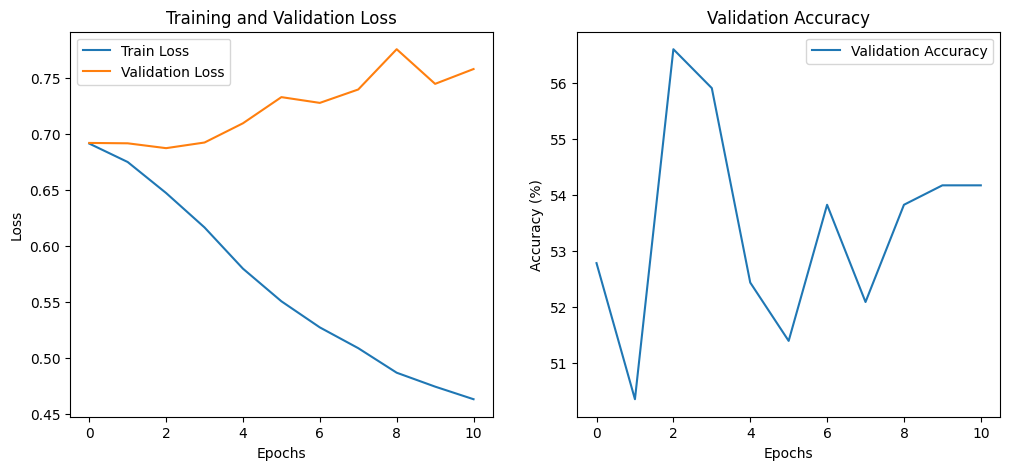

Test Loss: 0.6256, Test Accuracy: 70.14%
Test Subject 6: Test Acc = 70.14%, Test Loss = 0.6256
Training complete in 0m 36s

seed is 249
Val Subject 8:
Dataset:  dataset/aBNCI2014001R.pickle
Epoch [1/100], Train Loss: 0.6833, Val Acc: 66.32%
Epoch [2/100], Train Loss: 0.6549, Val Acc: 74.65%
Epoch [3/100], Train Loss: 0.6026, Val Acc: 82.64%
Epoch [4/100], Train Loss: 0.5466, Val Acc: 84.03%
Epoch [5/100], Train Loss: 0.5018, Val Acc: 83.68%
Epoch [6/100], Train Loss: 0.4504, Val Acc: 85.07%
Epoch [7/100], Train Loss: 0.4236, Val Acc: 84.72%
Epoch [8/100], Train Loss: 0.3867, Val Acc: 86.11%
Epoch [9/100], Train Loss: 0.3673, Val Acc: 85.76%
Epoch [10/100], Train Loss: 0.3464, Val Acc: 86.46%
Epoch [11/100], Train Loss: 0.4006, Val Acc: 81.60%
Epoch [12/100], Train Loss: 0.3239, Val Acc: 86.11%
Epoch [13/100], Train Loss: 0.3112, Val Acc: 87.15%
Epoch [14/100], Train Loss: 0.2980, Val Acc: 87.50%
Epoch [15/100], Train Loss: 0.3433, Val Acc: 85.42%
Epoch [16/100], Train Loss: 0.2745, Val

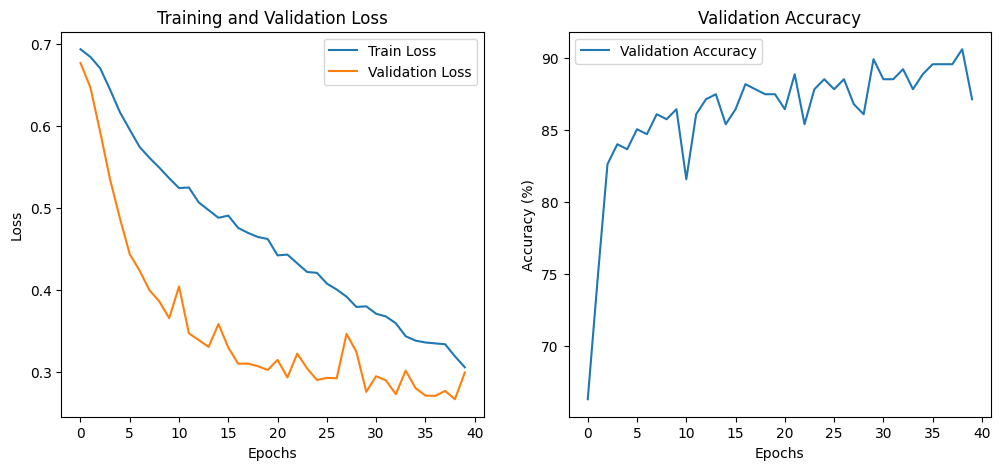

Test Loss: 0.8721, Test Accuracy: 58.68%
Test Subject 7: Test Acc = 58.68%, Test Loss = 0.8721
Training complete in 2m 7s

seed is 905
Val Subject 9:
Dataset:  dataset/aBNCI2014001R.pickle
Epoch [1/100], Train Loss: 0.6840, Val Acc: 50.00%
Epoch [2/100], Train Loss: 0.6906, Val Acc: 50.69%
Epoch [3/100], Train Loss: 0.7445, Val Acc: 50.69%
Epoch [4/100], Train Loss: 0.6897, Val Acc: 59.38%
Epoch [5/100], Train Loss: 0.7705, Val Acc: 55.56%
Epoch [6/100], Train Loss: 0.7029, Val Acc: 64.58%
Epoch [7/100], Train Loss: 0.8028, Val Acc: 60.07%
Epoch [8/100], Train Loss: 0.8900, Val Acc: 59.03%
Epoch [9/100], Train Loss: 0.9874, Val Acc: 55.21%
Epoch [10/100], Train Loss: 0.8750, Val Acc: 61.11%
Epoch [11/100], Train Loss: 1.0205, Val Acc: 57.29%
Epoch [12/100], Train Loss: 1.0482, Val Acc: 58.33%
Epoch [13/100], Train Loss: 1.0584, Val Acc: 57.99%
Epoch [14/100], Train Loss: 1.1033, Val Acc: 56.94%
Epoch [15/100], Train Loss: 1.2017, Val Acc: 55.56%
Epoch [16/100], Train Loss: 1.2247, Val 

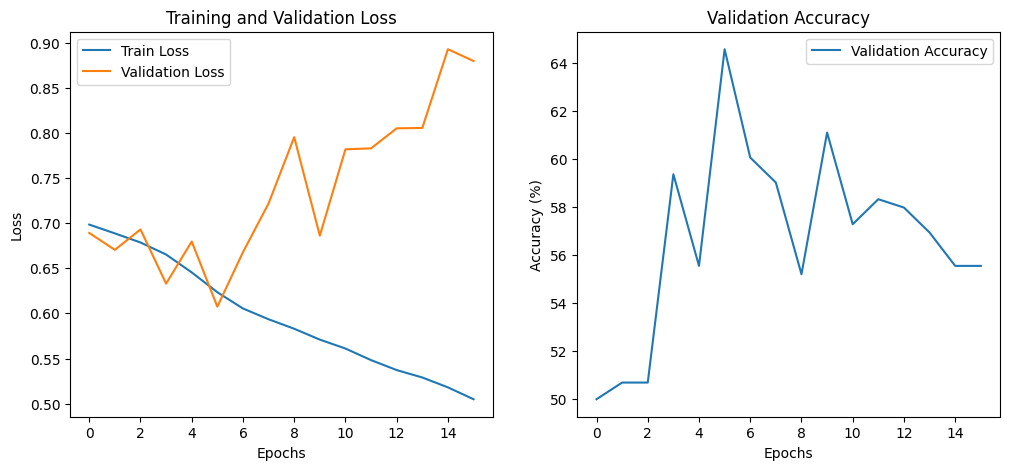

Test Loss: 0.4977, Test Accuracy: 75.35%
Test Subject 8: Test Acc = 75.35%, Test Loss = 0.4977
Training complete in 0m 52s

seed is 1375
Val Subject 1:
Dataset:  dataset/aBNCI2014001R.pickle
Epoch [1/100], Train Loss: 0.6890, Val Acc: 50.35%
Epoch [2/100], Train Loss: 0.6854, Val Acc: 59.72%
Epoch [3/100], Train Loss: 0.6773, Val Acc: 59.03%
Epoch [4/100], Train Loss: 0.6684, Val Acc: 62.85%
Epoch [5/100], Train Loss: 0.6523, Val Acc: 67.36%
Epoch [6/100], Train Loss: 0.6428, Val Acc: 74.31%
Epoch [7/100], Train Loss: 0.6278, Val Acc: 65.28%
Epoch [8/100], Train Loss: 0.6439, Val Acc: 72.57%
Epoch [9/100], Train Loss: 0.6380, Val Acc: 71.53%
Epoch [10/100], Train Loss: 0.7170, Val Acc: 72.92%
Epoch [11/100], Train Loss: 0.6365, Val Acc: 71.88%
Epoch [12/100], Train Loss: 0.7022, Val Acc: 72.57%
Epoch [13/100], Train Loss: 0.6337, Val Acc: 74.65%
Epoch [14/100], Train Loss: 0.6256, Val Acc: 73.61%
Epoch [15/100], Train Loss: 0.6089, Val Acc: 73.96%
Epoch [16/100], Train Loss: 0.6092, Va

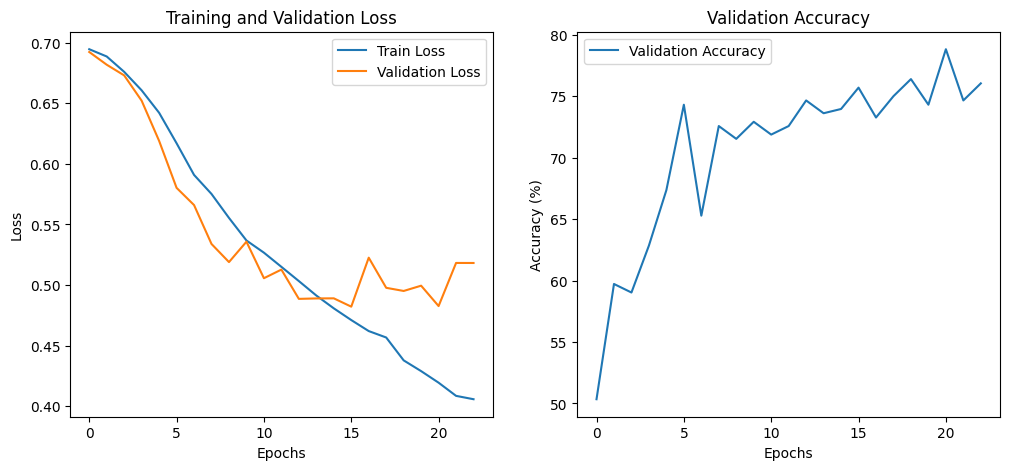

Test Loss: 0.9121, Test Accuracy: 63.54%
Test Subject 9: Test Acc = 63.54%, Test Loss = 0.9121
Training complete in 1m 13s

Average Test Accuracy: 67.36%
Average Test Loss: 0.6763
   Test Subject  Val Subject   Test Acc    Seed
0           1.0          2.0  78.472222  1546.0
1           2.0          3.0  55.902778  1582.0
2           3.0          4.0  90.972222  1944.0
3           4.0          5.0  60.416667   796.0
4           5.0          6.0  52.777778  1230.0
5           6.0          7.0  70.138889   911.0
6           7.0          8.0  58.680556   249.0
7           8.0          9.0  75.347222   905.0
8           9.0          1.0  63.541667  1375.0


In [43]:
# Assuming you have n subjects in your dataset
n_subjects = 9

# Results storage
all_test_accuracies = []
all_test_losses = []

# Initialize an empty DataFrame
results_df = pd.DataFrame(columns=['Test Subject', 'Val Subject', 'Test Acc', 'Seed'])

for test_sub in range(n_subjects):
    start_time = time.time()
    
    seed_n = np.random.randint(2021)
    print('seed is ' + str(seed_n))
    random.seed(seed_n)
    np.random.seed(seed_n)
    torch.manual_seed(seed_n)
    torch.cuda.manual_seed(seed_n)
    torch.cuda.manual_seed_all(seed_n)
    
    # Selecting the validation subject (can be the same or different from the test subject)
    val_sub = (test_sub + 1) % n_subjects
    print(f"Val Subject {val_sub + 1}:")

    # Initialize model and get source data for this iteration
    model, parameters, loss_functions = initialize_model(test_sub, val_sub, n_subjects)
    X_train, y_train, X_val, y_val, X_test, y_test = get_source_data(test_sub, val_sub, n_subjects)
    train_loader, val_loader = prepare_dataloaders(X_train, y_train, X_val, y_val, parameters['batch_size'])
    test_loader = prepare_dataloaders(X_test, y_test, X_test, y_test, parameters['batch_size'])[1]  # Only need test loader

    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr'], betas=(parameters['b1'], parameters['b2']))

    # Train the model
    early_stopping = EarlyStopping(patience=10, min_delta=0.01)
    trained_model, train_losses, val_losses, val_accuracies = train_model(model, optimizer, loss_functions, train_loader, val_loader, parameters, early_stopping)
    
    # Number of epochs trained is either the total number of epochs or until early stopping
    epochs_trained = parameters['n_epochs'] if not early_stopping.early_stop else early_stopping.counter
    
    # Plotting
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()
    
    # Test the model
    test_accuracy, test_loss = test_model(trained_model, loss_functions['criterion_cls'], test_loader)

    # Store results
    all_test_accuracies.append(test_accuracy)
    all_test_losses.append(test_loss)

    print(f"Test Subject {test_sub + 1}: Test Acc = {test_accuracy:.2f}%, Test Loss = {test_loss:.4f}")
    
    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('\n======================================')
    
    # Add the results to the DataFrame
    results_df = results_df.append({
        'Test Subject': test_sub + 1,
        'Val Subject': val_sub + 1,
        'Test Acc': test_accuracy,
        'Seed': seed_n
    }, ignore_index=True)

# Calculate average performance across all LOSO rounds
average_accuracy = np.mean(all_test_accuracies)
average_loss = np.mean(all_test_losses)

print(f"Average Test Accuracy: {average_accuracy:.2f}%")
print(f"Average Test Loss: {average_loss:.4f}")

# Display the results DataFrame
print(results_df)

## Utility Functions

In [ ]:
def save_model(model, path):
    """
    Save the trained model to a file.
    :param model: The trained model.
    :param path: File path to save the model.
    """
    torch.save(model.state_dict(), path)

def load_model(path):
    """
    Load a model from a file.
    :param path: File path to the model.
    :return: Loaded model.
    """
    # Instantiate the model
    model = model_class(*args, **kwargs)
    
    # Load the model state dict
    model.load_state_dict(torch.load(path))
    
    return model


In [ ]:
save_model(trained_model, 'results_2024_conf/model.pth')

In [ ]:
my_loaded_model = load_model(CCT, 'results_2024_conf/model.pth', 'left_hand', 'right_hand')